In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simps
from mpl_toolkits.mplot3d import axes3d
# import pymsteams
from time import time, localtime, strftime
from datetime import datetime
import os
# from scipy.interpolate import RegularGridInterpolator as rgi, interp1d
plt.rcParams['figure.figsize'] = [8, 8]
# plt.rcParams.update({'font.size' : 18})

path = r'C:\Users\fgbse\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240812_GEM_MBE_sims'

In [13]:
def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape

def lorentz_norm(x,delta,lw,grad,stark,length):
    norm_line_shape = lorentz(x,delta,lw,grad,stark,length)/max(lorentz(x,delta,lw,0,stark,length))
    return norm_line_shape

def lorentz_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/(2*np.pi) * (lw + grad*length/2*stark)/((delta + grad*stark*x)**2 + (1/2*(lw + grad*length/2*stark))**2)
    return OD*line_shape/max(1/(2*np.pi) * lw/(delta**2 + (1/2*lw)**2))

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def gauss_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/((lw + grad*length/2*stark)*np.sqrt(2*np.pi)) * np.exp(-1/2 * (delta + grad*stark*x)**2/(lw + grad*length/2*stark)**2)
    return OD*line_shape/max(1/(lw*np.sqrt(2*np.pi)) * np.exp(-1/2 * delta**2/lw**2))

def grad_switch(t,t_switch):
    if t > t_switch:
        return 1
    else:
        return -1
    
def gauss(t,t_peak,amp,sigma):    
    line_shape = amp*np.exp(-(t - t_peak)**2 / (2 * sigma**2))
    return line_shape

def MBE_pol_z0(t, alpha, t0, A, sigma, delta, x, grad, stark, t_switch, g, gamma, w):

    E = gauss(t,t0,A,sigma)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x)*alpha - (1j) * g * w * E

    return dalpha_dt

def interpolate_E(E,t_arr,tn):

    interp = np.interp(tn,t_arr,E)
    return interp

def MBE_pol_z(t, alpha, E, t_arr, delta, x_n, grad, stark, t_switch, g, gamma, w):
    
    Ez = interpolate_E(E,t_arr,t)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x_n)*alpha - (1j) * g * w * Ez

    return dalpha_dt

def MBE_field(x, E, t0, t1, E0, delta, alpha0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0 - OD*E0
    E1 = E[:,0]

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            # args=(E[:,0], t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=False,
                            vectorized=False,
                            method='RK23')
        
    alpha = sol_alpha_z.y.T

    dE_dx = simps(lorentz_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=1)

    print(x)

    return dE_dx

In [14]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 0.01#0.01#0.31                            # Polarization decay rate
g = 2000#2000#406                                 # Transition coupling strength
t_input = 5                                  # Gaussian pulse peak time
sigma = 0.5/np.sqrt(2*np.log(2))        # Gaussian pulse sigma
OD = 0.1                                  # Optical depth used in Lorentzian
grad = 3e4#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.1                                  # Zero field absorption linewidth
t_switch = 20                            # Gradient direction switch time
A = 3.5e-3#3                              # Electric field magnitude
L = 16475/2                               # Optical path length
t_total = 50
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 10  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK23')
    
E = sol.y

with open(path + r'E.npy','wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(path + r'alpha.npy','wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

for i in range(Nx):
    P[:,i] = 1j * simps(lorentz(x_arr[i],delta,lw,grad,stark,L)*alpha[i,:,:])
    print(i)

with open(path + r'P.npy','wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
P = np.rot90(P)

TypeError: only size-1 arrays can be converted to Python scalars

In [369]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(path + r'optical field')

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.semilogy(t_arr,np.sum(abs(E),axis=0),label=r'$\mid E \mid$')
plt.semilogy(t_arr,np.sum(np.imag(E),axis=0),label=r'$\Im(E)$')
plt.semilogy(t_arr,np.sum(np.real(E),axis=0),label=r'$\Re(E)$')
plt.semilogy(t_arr,abs(E0*L),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(path + r'optical field 2D')

plt.figure()
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
alpha_sum = np.rot90(np.sum(alpha, axis=2))
plt.subplot(2,1,1)
plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\mid \alpha \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Re(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Im(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(path + r'atomic polarization')

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(path + r'polarization density')

plt.figure()
plt.plot(lorentz(x_arr,delta,lw,grad,stark,L),label='broadened')
plt.plot(lorentz(x_arr,delta,lw,grad,0,L),label='unbroadened')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(path + r'controlled reversible inhomogeneous broadening')

plt.show()

with open(path + 'params.txt', 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()

In [407]:
P = np.zeros((Nx,Nt),dtype=np.complex128)

for i in range(Nx):
    N = lorentz(x_arr[i],delta,lw,grad,stark,L)
    P[i,:] = 1j * simps(N[:,np.newaxis]*alpha[i,:,:],axis=2)


plt.imshow(np.imag(P))

ValueError: operands could not be broadcast together with shapes (50,1) (100,50) 

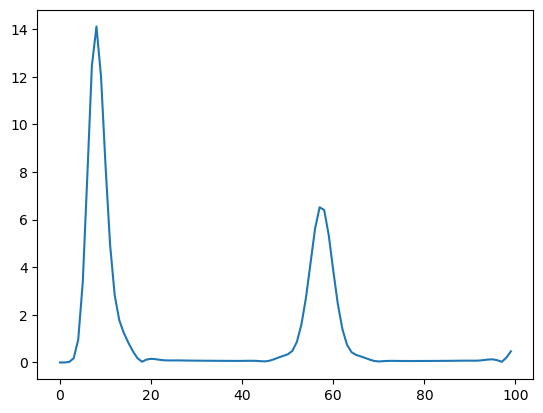

In [72]:
i = 0

CRIB = lorentz(x_arr[i],delta,lw,grad,stark,L)
A = alpha[i,:,:]

# plt.subplot(1,4,1)
# plt.plot(CRIB)

# plt.subplot(1,4,2)
# plt.imshow(abs(A))
# plt.subplot(1,4,3)
# plt.imshow(np.imag(A))
# plt.subplot(1,4,4)
# plt.imshow(np.real(A))

plt.plot(abs(simps(CRIB*A)))


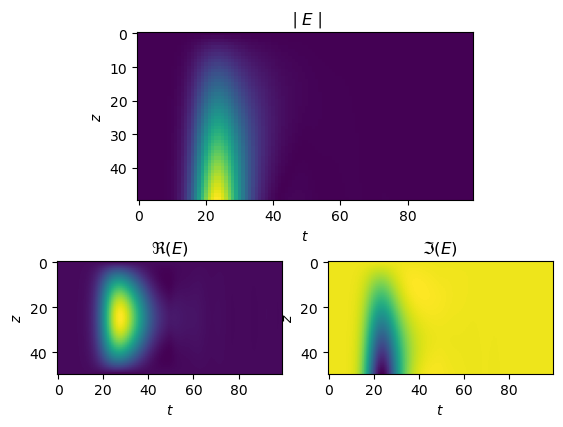

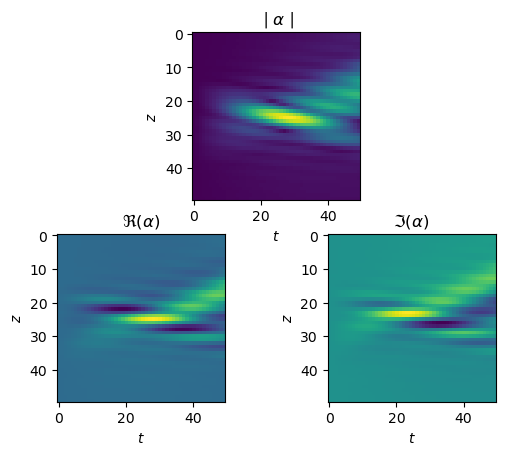

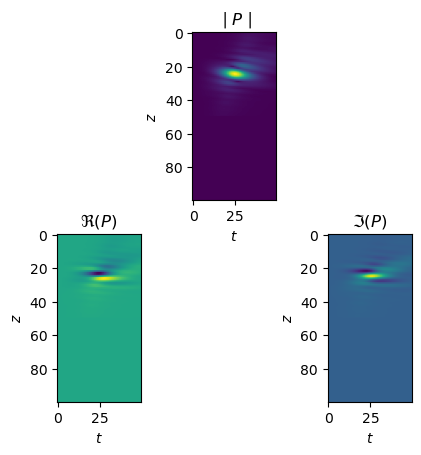

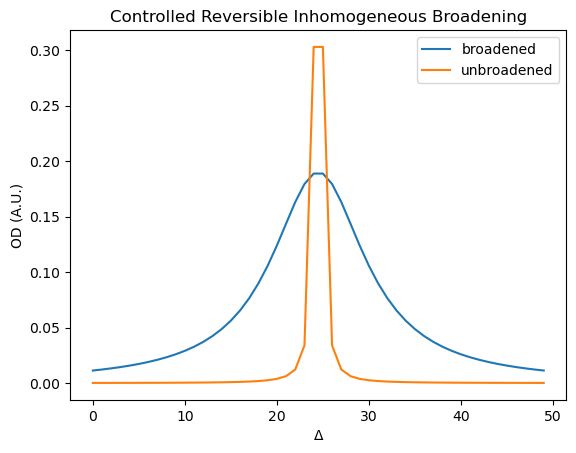

In [412]:
plt.subplot(2,1,1)
plt.imshow(abs(E))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# alpha_sum = np.rot90(np.sum(alpha, axis=0))
alpha_sum = np.sum(alpha, axis=1)
plt.subplot(2,1,1)
plt.imshow(abs(alpha_sum))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid \alpha \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha_sum))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha_sum))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P))#,extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
plt.plot(lorentz(x_arr,delta,lw,grad,stark,L),label='broadened')
plt.plot(lorentz(x_arr,delta,lw,grad,0,L),label='unbroadened')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()